### Multi step model (simple encoder-decoder)

In this notebook, we demonstrate how to:
- prepare time series data for training a RNN forecasting model
- get data in the required shape for the keras API
- implement a RNN model in keras to predict the next 3 steps ahead (time *t+1* to *t+3*) in the time series. This model uses a simple encoder decoder approach in which the final hidden state of the encoder is replicated across each time step of the decoder. 
- enable early stopping to reduce the likelihood of model overfitting
- evaluate the model on a test dataset

The data in this example is taken from the GEFCom2014 forecasting competition<sup>1</sup>. It consists of 3 years of hourly electricity load and temperature values between 2012 and 2014. The task is to forecast future values of electricity load.

<sup>1</sup>Tao Hong, Pierre Pinson, Shu Fan, Hamidreza Zareipour, Alberto Troccoli and Rob J. Hyndman, "Probabilistic energy forecasting: Global Energy Forecasting Competition 2014 and beyond", International Journal of Forecasting, vol.32, no.3, pp 896-913, July-September, 2016.

In [65]:
import os
import warnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt
from collections import UserDict
from IPython.display import Image
%matplotlib inline

from common.utils import load_data, mape, TimeSeriesTensor, create_evaluation_df

pd.options.display.float_format = '{:,.20f}'.format
np.set_printoptions(precision=20)
warnings.filterwarnings("ignore")

In [66]:
df = pd.read_csv("Cleaned1.csv" , parse_dates = True)
a = pd.to_datetime(df['Epoch_Time_of_Clock'])
print(type(a[0]))
df = df.drop(['Unnamed: 0', 'Unnamed: 0.1' ,'sqrt_A' ,'e' ,'PRN','SV_Clock_Bias', 'SV_Clock_Drift', 'SV_Clock_Drift_Rate', 'IODE', 'Crs',
       'Del_n', 'i0', 'Cuc','Cus','Toe', 'Cic', 'OMEGA',
       'Cis', 'Crc', 'omega', 'OMEGA_dot', 'I_dot', 'Codes', 'GPS_week',
       'L2_P_Data_flag', 'SV_accuracy', 'SV_health', 'Tgd', 'IODC', 'T_Tx',
       'Fit_Interval' ,'Epoch_Time_of_Clock' ],axis =1 )
df.head()
#df = df.set_index(['Epoch_Time_of_Clock'])
df = df.set_index(a)
df.head()

<class 'pandas._libs.tslibs.timestamps.Timestamp'>


,M0
Epoch_Time_of_Clock,
2017-11-01 14:00:00,2.75563657824999985735
2017-11-01 16:00:00,-2.47738129409000018555
2017-11-01 18:00:00,-1.42713945816000009614
2017-11-01 20:00:00,-0.37692427951800006047
2017-11-01 22:00:00,0.67320921416299994711


In [67]:
var_name = 'M0'
sat_var = 1

In [68]:

df = df.iloc[5 : , :]

In [69]:

df.head(7)

,M0
Epoch_Time_of_Clock,
2017-11-02 12:00:00,1.74155834787999985735
2017-11-02 14:00:00,2.79191362578999990873
2017-11-02 16:00:00,-2.44110202145000032559
2017-11-02 18:00:00,-1.39090920497000003486
2017-11-02 20:00:00,-0.34065683018100001433
2017-11-02 22:00:00,0.70946508742899994093
2017-11-03 12:00:00,1.77754211692000008149


# Enter number of entries per day

In [70]:
entry = 6
print(df.shape[0])
no_of_entries = df.shape[0]//entry
valid = (no_of_entries * 70)//100
test = (no_of_entries * 85)//100
indexes = df.index
#print(valid , test , indexes)
valid_start_dt = indexes[int(valid)*int(entry)] 
test_start_dt = indexes [int(test)*int(entry)] 
test_start_dt = str(test_start_dt)
valid_start_dt = str(valid_start_dt)
print(test_start_dt,valid_start_dt)
print(type(test_start_dt))

168
2017-11-25 12:00:00 2017-11-21 12:00:00
<class 'str'>



Load data into Pandas dataframe

# enter lag and no. of outputs

In [71]:
"""total = len(df)
t = total*70/100
t = round(t)
indexes = df.index
valid_start_dt = str(indexes[t])
t = total*85/100
t = round(t)
test_start_dt = str(indexes[t])
print(valid_start_dt , test_start_dt)
"""
T = 6
HORIZON = 6

Create training set containing only the model features

In [72]:
train = df.copy()[df.index < valid_start_dt][[var_name ]]
train.head()

,M0
Epoch_Time_of_Clock,
2017-11-02 12:00:00,1.74155834787999985735
2017-11-02 14:00:00,2.79191362578999990873
2017-11-02 16:00:00,-2.44110202145000032559
2017-11-02 18:00:00,-1.39090920497000003486
2017-11-02 20:00:00,-0.34065683018100001433


In [73]:
train.tail(6)

,M0
Epoch_Time_of_Clock,
2017-11-20 12:00:00,2.38734889161999985774
2017-11-20 14:00:00,-2.84562811410000016110
2017-11-20 16:00:00,-1.79562747532000011041
2017-11-20 18:00:00,-0.74524204666500004635
2017-11-20 20:00:00,0.30496156175299998781
2017-11-20 22:00:00,1.35263249910000005194


Scale data to be in range (0, 1). This transformation should be calibrated on the training set only. This is to prevent information from the validation or test sets leaking into the training data.

# Enter variable to be predicted

In [74]:
from sklearn.preprocessing import StandardScaler




y_scalar = StandardScaler()
y_scalar.fit(train[[var_name]])


X_scaler = StandardScaler()
train[[var_name]] = X_scaler.fit_transform(train)

Use the TimeSeriesTensor convenience class to:
1. Shift the values of the time series to create a Pandas dataframe containing all the data for a single training example
2. Discard any samples with missing values
3. Transform this Pandas dataframe into a numpy array of shape (samples, time steps, features) for input into Keras

The class takes the following parameters:

- **dataset**: original time series
- **H**: the forecast horizon
- **tensor_structure**: a dictionary discribing the tensor structure in the form { 'tensor_name' : (range(max_backward_shift, max_forward_shift), [feature, feature, ...] ) }
- **freq**: time series frequency
- **drop_incomplete**: (Boolean) whether to drop incomplete samples

In [75]:
tensor_structure = {'X':(range(-T+1, 1), [var_name])}
train_inputs = TimeSeriesTensor(train, var_name, HORIZON, {'X':(range(-T+1, 1), [var_name])} ,freq = None)

In [76]:
train_inputs.dataframe

tensor                               target                          \
feature                                   y                           
time step                               t+1                     t+2   
Epoch_Time_of_Clock                                                   
2017-11-02 22:00:00  0.97149827648026854110  1.54706758832215296451   
2017-11-03 12:00:00  1.54706758832215296451 -1.32049038427065390522   
2017-11-03 14:00:00 -1.32049038427065390522 -0.74503367767810235733   
2017-11-03 16:00:00 -0.74503367767810235733 -0.16951611191441870452   
2017-11-03 18:00:00 -0.16951611191441870452  0.40593030959689968551   
2017-11-03 20:00:00  0.40593030959689968551  0.99107315416209706971   
2017-11-03 22:00:00  0.99107315416209706971  1.56661205245382562090   
2017-11-04 12:00:00  1.56661205245382562090 -1.30094033749504678354   
2017-11-04 14:00:00 -1.30094033749504678354 -0.72547449216540149664   
2017-11-04 16:00:00 -0.72547449216540149664 -0.14997325187118248913   
2017-11-04 18:00:00 -0.14997325187118248913  0.42548753508963860215   
2017-11-04 20:00:00  0.42548753508963860215  1.01059007542888767972   
2017-11-04 22:00:00  1.01059007542888767972  1.58607835314813816474   
2017-11-05 12:00:00  1.58607835314813816474 -1.28147774039796580325   
2017-11-05 14:00:00 -1.28147774039796580325 -0.70596060351615597117   
2017-11-05 16:00:00 -0.70596060351615597117 -0.13049053352201739342   
2017-11-05 18:00:00 -0.13049053352201739342  0.44498440164337843550   
2017-11-05 20:00:00  0.44498440164337843550  1.03017152177647197675   
2017-11-05 22:00:00  1.03017152177647197675  1.60560786823135837054   
2017-11-06 12:00:00  1.60560786823135837054 -1.26196437201319744403   
2017-11-06 14:00:00 -1.26196437201319744403 -0.68637635862976542622   
2017-11-06 16:00:00 -0.68637635862976542622 -0.11093615947458104753   
2017-11-06 18:00:00 -0.11093615947458104753  0.46454181953144779715   
2017-11-06 20:00:00  0.46454181953144779715  1.04988553669452100436   
2017-11-06 22:00:00  1.04988553669452100436  1.62528605770999456936   
2017-11-07 12:00:00  1.62528605770999456936 -1.24231045229184555723   
2017-11-07 14:00:00 -1.24231045229184555723 -0.66667289093242254605   
2017-11-07 16:00:00 -0.66667289093242254605 -0.09124631891235965298   
2017-11-07 18:00:00 -0.09124631891235965298  0.48421964185492205601   
2017-11-07 20:00:00  0.48421964185492205601  1.06969547627082084418   
...                                     ...                     ...   
2017-11-15 12:00:00 -1.66083514037099644334 -1.08532226742983128887   
2017-11-15 14:00:00 -1.08532226742983128887 -0.50982954540212144234   
2017-11-15 16:00:00 -0.50982954540212144234  0.06562160099541189395   
2017-11-15 18:00:00  0.06562160099541189395  0.63981227454587641379   
2017-11-15 20:00:00  0.63981227454587641379  1.22650522973327302800   
2017-11-15 22:00:00  1.22650522973327302800 -1.64105738197167561054   
2017-11-16 12:00:00 -1.64105738197167561054 -1.06555178234357450506   
2017-11-16 14:00:00 -1.06555178234357450506 -0.49000467121269042359   
2017-11-16 16:00:00 -0.49000467121269042359  0.08544418007944350191   
2017-11-16 18:00:00  0.08544418007944350191  0.65961785879016054945   
2017-11-16 20:00:00  0.65961785879016054945  1.24636755349221317601   
2017-11-16 22:00:00  1.24636755349221317601 -1.62119685229034127261   
2017-11-17 12:00:00 -1.62119685229034127261 -1.04571506226797095174   
2017-11-17 14:00:00 -1.04571506226797095174 -0.47012596426327568633   
2017-11-17 16:00:00 -0.47012596426327568633  0.10532664352984670575   
2017-11-17 18:00:00  0.10532664352984670575  0.68075441079648812970   
2017-11-17 20:00:00  0.68075441079648812970  1.26622875655884770119   
2017-11-17 22:00:00  1.26622875655884770119 -1.60133299257770378432   
2017-11-18 12:00:00 -1.60133299257770378432 -1.02588661996663210729   
2017-11-18 14:00:00 -1.02588661996663210729 -0.45027665918926590427   
2017-11-18 16:00:00 -0.45027665918926590427  0.12390608931554202010   
2017-11-18 18:00:00  0.1

In [77]:
train_inputs['target'].shape

(103, 6)

Construct validation set (keeping T hours from the training set in order to construct initial features)

In [78]:
look_back_dt = dt.datetime.strptime(valid_start_dt, '%Y-%m-%d %H:%M:%S') - dt.timedelta(hours=T-1)
valid = df.copy()[(df.index >=look_back_dt) & (df.index < test_start_dt)][[var_name]]
valid[[var_name]] = X_scaler.transform(valid)
valid_inputs = TimeSeriesTensor(valid, var_name, HORIZON, tensor_structure,freq = None)
valid_inputs.dataframe.head()

tensor                               target                          \
feature                                   y                           
time step                               t+1                     t+2   
Epoch_Time_of_Clock                                                   
2017-11-21 22:00:00  1.34457563960173520634 -1.52294861827696736967   
2017-11-22 12:00:00 -1.52294861827696736967 -0.94759221972007401380   
2017-11-22 14:00:00 -0.94759221972007401380 -0.37207891388968961088   
2017-11-22 16:00:00 -0.37207891388968961088  0.20342568128104679404   
2017-11-22 18:00:00  0.20342568128104679404  0.77756026304265013493   

tensor                                                               \
feature                                                               
time step                               t+3                     t+4   
Epoch_Time_of_Clock                                                   
2017-11-21 22:00:00 -0.94759221972007401380 -0.37207891388968961088   
2017-11-22 12:00:00 -0.37207891388968961088  0.20342568128104679404   
2017-11-22 14:00:00  0.20342568128104679404  0.77756026304265013493   
2017-11-22 16:00:00  0.77756026304265013493  1.36395205041092215659   
2017-11-22 18:00:00  1.36395205041092215659 -1.50356867622531464868   

tensor                                                               \
feature                                                               
time step                               t+5                     t+6   
Epoch_Time_of_Clock                                                   
2017-11-21 22:00:00  0.20342568128104679404  0.77756026304265013493   
2017-11-22 12:00:00  0.77756026304265013493  1.36395205041092215659   
2017-11-22 14:00:00  1.36395205041092215659 -1.50356867622531464868   
2017-11-22 16:00:00 -1.50356867622531464868 -0.92819253078669405888   
2017-11-22 18:00:00 -0.92819253078669405888 -0.35271294608666059478   

tensor                                    X                          \
feature                                  M0                           
time step                               t-5                     t-4   
Epoch_Time_of_Clock                                                   
2017-11-21 22:00:00  1.32516742759281136443 -1.54236527479269236451   
2017-11-22 12:00:00 -1.54236527479269236451 -0.96700921132288075732   
2017-11-22 14:00:00 -0.96700921132288075732 -0.39145790839891569934   
2017-11-22 16:00:00 -0.39145790839891569934  0.18276043628053229018   
2017-11-22 18:00:00  0.18276043628053229018  0.75942596102784309942   

tensor                                                               \
feature                                                               
time step                               t-3                     t-2   
Epoch_Time_of_Clock                                                   
2017-11-21 22:00:00 -0.96700921132288075732 -0.39145790839891569934   
2017-11-22 12:00:00 -0.39145790839891569934  0.18276043628053229018   
2017-11-22 14:00:00  0.18276043628053229018  0.75942596102784309942   
2017-11-22 16:00:00  0.75942596102784309942  1.34457563960173520634   
2017-11-22 18:00:00  1.34457563960173520634 -1.52294861827696736967   

tensor                                                               
feature                                                              
time step                               t-1                       t  
Epoch_Time_of_Clock                                                  
2017-11-21 22:00:00  0.18276043628053229018  0.75942596102784309942  
2017-11-22 12:00:00  0.75942596102784309942  1.34457563960173520634  
2017-11-22 14:00:00  1.34457563960173520634 -1.52294861827696736967  
2017-11-22 16:00:00 -1.52294861827696736967 -0.94759221972007401380  
2017-11-22 18:00:00 -0.94759221972007401380 -0.37207891388968961088

## Implement the RNN

We will implement a RNN forecasting model with the following structure:

In [79]:
#Image('./images/simple_encoder_decoder.png')

In [80]:
from keras.models import Model, Sequential
from keras.layers import LSTM, Dense, RepeatVector, TimeDistributed, Flatten
from keras.callbacks import EarlyStopping ,ModelCheckpoint

In [81]:
LATENT_DIM = 64
BATCH_SIZE = 8
EPOCHS = 10

In [82]:
model = Sequential()
model.add(LSTM(LATENT_DIM, input_shape=(T,1 )))
model.add(RepeatVector(HORIZON))
model.add(LSTM(LATENT_DIM, return_sequences=True))
model.add(TimeDistributed(Dense(1)))
model.add(Flatten())

In [83]:
model.compile(optimizer='RMSprop', loss='mse')

In [84]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 64)                16896     
_________________________________________________________________
repeat_vector_2 (RepeatVecto (None, 6, 64)             0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 6, 64)             33024     
_________________________________________________________________
time_distributed_2 (TimeDist (None, 6, 1)              65        
_________________________________________________________________
flatten_2 (Flatten)          (None, 6)                 0         
Total params: 49,985
Trainable params: 49,985
Non-trainable params: 0
_________________________________________________________________


In [85]:
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=500)

In [88]:
best_val = ModelCheckpoint(str(sat_var) +'_' +  var_name + '_{epoch:02d}.h5', save_best_only=True, mode='min', period=1)

In [89]:
history = model.fit(train_inputs['X'],
          train_inputs['target'],
          batch_size=BATCH_SIZE,
          epochs=EPOCHS,
          validation_data=(valid_inputs['X'], valid_inputs['target']),
          callbacks=[earlystop ,best_val],
          verbose=1 , shuffle = False)

Train on 103 samples, validate on 13 samples
Epoch 1/10
103/103 [==============================] - 0s 2ms/step - loss: 0.6514 - val_loss: 0.5895
Epoch 2/10
103/103 [==============================] - 0s 1ms/step - loss: 0.6319 - val_loss: 0.5660
Epoch 3/10
103/103 [==============================] - 0s 2ms/step - loss: 0.6085 - val_loss: 0.5382
Epoch 4/10
103/103 [==============================] - 0s 2ms/step - loss: 0.5816 - val_loss: 0.5073
Epoch 5/10
103/103 [==============================] - 0s 2ms/step - loss: 0.5521 - val_loss: 0.4745
Epoch 6/10
103/103 [==============================] - 0s 2ms/step - loss: 0.5213 - val_loss: 0.4402
Epoch 7/10
103/103 [==============================] - 0s 2ms/step - loss: 0.4896 - val_loss: 0.4045
Epoch 8/10
103/103 [==============================] - 0s 2ms/step - loss: 0.4571 - val_loss: 0.3669
Epoch 9/10
103/103 [==============================] - 0s 2ms/step - loss: 0.4230 - val_loss: 0.3276
Epoch 10/10
103/103 [==============================] - 

In [91]:
best_epoch = np.argmin(np.array(history.history['val_loss']))+1
model.load_weights(str(sat_var) +'_' +  var_name + '_{:02d}.h5'.format(best_epoch))

## Evaluate the model

In [92]:
look_back_dt = dt.datetime.strptime(test_start_dt, '%Y-%m-%d %H:%M:%S') - dt.timedelta(hours=T-1)
test = df.copy()[test_start_dt:][[var_name]]
test[[var_name]] = X_scaler.transform(test)
test_inputs = TimeSeriesTensor(test, var_name, HORIZON, tensor_structure,freq =None)
test_inputs.dataframe.head()

tensor                               target                          \
feature                                   y                           
time step                               t+1                     t+2   
Epoch_Time_of_Clock                                                   
2017-11-25 22:00:00  1.42264899709863401611 -1.44489355748819936487   
2017-11-26 12:00:00 -1.44489355748819936487 -0.86940384562911754429   
2017-11-26 14:00:00 -0.86940384562911754429 -0.29394991913270529516   
2017-11-26 16:00:00 -0.29394991913270529516  0.28025847474706699902   
2017-11-26 18:00:00  0.28025847474706699902  0.85710149136456081909   

tensor                                                               \
feature                                                               
time step                               t+3                     t+4   
Epoch_Time_of_Clock                                                   
2017-11-25 22:00:00 -0.86940384562911754429 -0.29394991913270529516   
2017-11-26 12:00:00 -0.29394991913270529516  0.28025847474706699902   
2017-11-26 14:00:00  0.28025847474706699902  0.85710149136456081909   
2017-11-26 16:00:00  0.85710149136456081909  1.44252862112686730534   
2017-11-26 18:00:00  1.44252862112686730534 -1.42502527190264638435   

tensor                                                               \
feature                                                               
time step                               t+5                     t+6   
Epoch_Time_of_Clock                                                   
2017-11-25 22:00:00  0.28025847474706699902  0.85710149136456081909   
2017-11-26 12:00:00  0.85710149136456081909  1.44252862112686730534   
2017-11-26 14:00:00  1.44252862112686730534 -1.42502527190264638435   
2017-11-26 16:00:00 -1.42502527190264638435 -0.84951452812616812249   
2017-11-26 18:00:00 -0.84951452812616812249 -0.27404074572499409479   

tensor                                    X                          \
feature                                  M0                           
time step                               t-5                     t-4   
Epoch_Time_of_Clock                                                   
2017-11-25 22:00:00  1.40293033986278592451 -1.46460083940808849512   
2017-11-26 12:00:00 -1.46460083940808849512 -0.88914820115081039109   
2017-11-26 14:00:00 -0.88914820115081039109 -0.31370078399850698236   
2017-11-26 16:00:00 -0.31370078399850698236  0.26051973393629329623   
2017-11-26 18:00:00  0.26051973393629329623  0.83733695527132889769   

tensor                                                               \
feature                                                               
time step                               t-3                     t-2   
Epoch_Time_of_Clock                                                   
2017-11-25 22:00:00 -0.88914820115081039109 -0.31370078399850698236   
2017-11-26 12:00:00 -0.31370078399850698236  0.26051973393629329623   
2017-11-26 14:00:00  0.26051973393629329623  0.83733695527132889769   
2017-11-26 16:00:00  0.83733695527132889769  1.42264899709863401611   
2017-11-26 18:00:00  1.42264899709863401611 -1.44489355748819936487   

tensor                                                               
feature                                                              
time step                               t-1                       t  
Epoch_Time_of_Clock                                                  
2017-11-25 22:00:00  0.26051973393629329623  0.83733695527132889769  
2017-11-26 12:00:00  0.83733695527132889769  1.42264899709863401611  
2017-11-26 14:00:00  1.42264899709863401611 -1.44489355748819936487  
2017-11-26 16:00:00 -1.44489355748819936487 -0.86940384562911754429  
2017-11-26 18:00:00 -0.86940384562911754429 -0.29394991913270529516

In [93]:
test_inputs.dataframe.head(50)

tensor                               target                          \
feature                                   y                           
time step                               t+1                     t+2   
Epoch_Time_of_Clock                                                   
2017-11-25 22:00:00  1.42264899709863401611 -1.44489355748819936487   
2017-11-26 12:00:00 -1.44489355748819936487 -0.86940384562911754429   
2017-11-26 14:00:00 -0.86940384562911754429 -0.29394991913270529516   
2017-11-26 16:00:00 -0.29394991913270529516  0.28025847474706699902   
2017-11-26 18:00:00  0.28025847474706699902  0.85710149136456081909   
2017-11-26 20:00:00  0.85710149136456081909  1.44252862112686730534   
2017-11-26 22:00:00  1.44252862112686730534 -1.42502527190264638435   
2017-11-27 12:00:00 -1.42502527190264638435 -0.84951452812616812249   
2017-11-27 14:00:00 -0.84951452812616812249 -0.27404074572499409479   
2017-11-27 16:00:00 -0.27404074572499409479  0.30015402823265979748   
2017-11-27 18:00:00  0.30015402823265979748  0.87699638750026365219   
2017-11-27 20:00:00  0.87699638750026365219  1.46251037533019556669   
2017-11-27 22:00:00  1.46251037533019556669 -1.40505091126014880487   
2017-11-28 12:00:00 -1.40505091126014880487 -0.82954241368498748965   
2017-11-28 14:00:00 -0.82954241368498748965 -0.25404125115398629164   
2017-11-28 16:00:00 -0.25404125115398629164  0.32014036142260249296   
2017-11-28 18:00:00  0.32014036142260249296  0.89694905246799561116   
2017-11-28 20:00:00  0.89694905246799561116  1.48249038115160325368   
2017-11-28 22:00:00  1.48249038115160325368 -1.38507162290867835708   

tensor                                                               \
feature                                                               
time step                               t+3                     t+4   
Epoch_Time_of_Clock                                                   
2017-11-25 22:00:00 -0.86940384562911754429 -0.29394991913270529516   
2017-11-26 12:00:00 -0.29394991913270529516  0.28025847474706699902   
2017-11-26 14:00:00  0.28025847474706699902  0.85710149136456081909   
2017-11-26 16:00:00  0.85710149136456081909  1.44252862112686730534   
2017-11-26 18:00:00  1.44252862112686730534 -1.42502527190264638435   
2017-11-26 20:00:00 -1.42502527190264638435 -0.84951452812616812249   
2017-11-26 22:00:00 -0.84951452812616812249 -0.27404074572499409479   
2017-11-27 12:00:00 -0.27404074572499409479  0.30015402823265979748   
2017-11-27 14:00:00  0.30015402823265979748  0.87699638750026365219   
2017-11-27 16:00:00  0.87699638750026365219  1.46251037533019556669   
2017-11-27 18:00:00  1.46251037533019556669 -1.40505091126014880487   
2017-11-27 20:00:00 -1.40505091126014880487 -0.82954241368498748965   
2017-11-27 22:00:00 -0.82954241368498748965 -0.25404125115398629164   
2017-11-28 12:00:00 -0.25404125115398629164  0.32014036142260249296   
2017-11-28 14:00:00  0.32014036142260249296  0.89694905246799561116   
2017-11-28 16:00:00  0.89694905246799561116  1.48249038115160325368   
2017-11-28 18:00:00  1.48249038115160325368 -1.38507162290867835708   
2017-11-28 20:00:00 -1.38507162290867835708 -0.80958586876503502161   
2017-11-28 22:00:00 -0.80958586876503502161 -0.23405948733149445351   

tensor                                                               \
feature                                                               
time step                               t+5                     t+6   
Epoch_Time_of_Clock                                                   
2017-11-25 22:00:00  0.28025847474706699902  0.85710149136456081909   
2017-11-26 12:00:00  0.85710149136456081909  1.44252862112686730534   
2017-11-26 14:00:00  1.44252862112686730534 -1.42502527190264638435   
2017-11-26 16:00:00 -1.42502527190264638435 -0.84951452812616812249   
2017-11-26 18:00:00 -0.84951452812616812249 -0.27404074572499409479   
2017-11-26 20:00:00 -0.27404074572499409479  0.30015402823265979748   
2017-11-26 22:00:00  0

In [94]:
test_inputs.dataframe.shape

(19, 12)

In [95]:
predictions = model.predict(test_inputs['X'])

In [96]:
predictions

array([[ 0.06899707 , -0.67461026 , -0.94672906 , -0.48929042 ,
         0.232397   ,  0.99168015 ],
       [-1.477754   , -1.1476481  , -0.42725837 ,  0.20912625 ,
         0.67058086 ,  0.98733723 ],
       [-0.6575615  , -0.44775796 ,  0.17415996 ,  0.9053172  ,
         0.62585795 , -1.3780185  ],
       [ 0.31051505 ,  0.7326393  ,  0.9548485  ,  0.4765928  ,
        -0.589035   , -1.4326855  ],
       [ 0.73210883 ,  0.88676643 ,  0.34611967 , -0.46579692 ,
        -0.7825737  , -0.52646947 ],
       [ 0.68750745 ,  0.38768983 , -0.5096185  , -0.83458793 ,
        -0.519251   ,  0.03516379 ],
       [ 0.06724793 , -0.6603593  , -0.92257535 , -0.46197647 ,
         0.26073703 ,  1.0162026  ],
       [-1.4717427  , -1.1407193  , -0.431458   ,  0.1952841  ,
         0.6519459  ,  0.9675307  ],
       [-0.64482665 , -0.43299037 ,  0.18722425 ,  0.9031109  ,
         0.58800846 , -1.4043443  ],
       [ 0.31816903 ,  0.7427808  ,  0.96383107 ,  0.48767474 ,
        -0.5696517  , -1.40

In [97]:
eval_df = create_evaluation_df(predictions, test_inputs, HORIZON, y_scalar)
print(eval_df.head())
print(eval_df.tail())
print(eval_df.shape)


            timestamp    h              prediction                  actual
0 2017-11-25 22:00:00  t+1  0.13056878368729665785  2.60084650804000006019
1 2017-11-26 12:00:00  t+1 -2.69209532226841208313 -2.63212834719000010608
2 2017-11-26 14:00:00  t+1 -1.19532701624072745794 -1.58191788499999996809
3 2017-11-26 16:00:00  t+1  0.57131463873564236611 -0.53177272747400006203
4 2017-11-26 18:00:00  t+1  1.34068061518598558024  0.51609945912299992621
              timestamp    h              prediction                  actual
109 2017-11-28 14:00:00  t+6 -2.60151224277160775245 -2.52295937288999994053
110 2017-11-28 16:00:00  t+6 -2.52456226611615752731 -1.47275613312999986704
111 2017-11-28 18:00:00  t+6 -0.93584546012215064081 -0.42247875267899998031
112 2017-11-28 20:00:00  t+6  0.13577558453970192676  0.62532987744199997060
113 2017-11-28 22:00:00  t+6  1.94456911710065605270  1.67783342129999990533
(114, 4)


In [98]:
eval_df['APE'] = (eval_df['prediction'] - eval_df['actual']).abs() / eval_df['actual']
eval_df.groupby('h')['APE'].mean()

h
t+1    0.07188445890585284936
t+2    0.08841304263202960645
t+3   -0.02071174450008412757
t+4   -0.09622322335249848535
t+5   -0.10256118318238005571
t+6   -0.06546954834452932415
Name: APE, dtype: float64

In [99]:
mape(eval_df['prediction'], eval_df['actual'])
from sklearn.metrics import mean_absolute_error
a = mean_absolute_error(eval_df['prediction'], eval_df['actual'])
a

0.7307153267789616

Plot actuals vs predictions at each horizon for first week of the test period. As is to be expected, predictions for one step ahead (*t+1*) are more accurate than those for 2 or 3 steps ahead

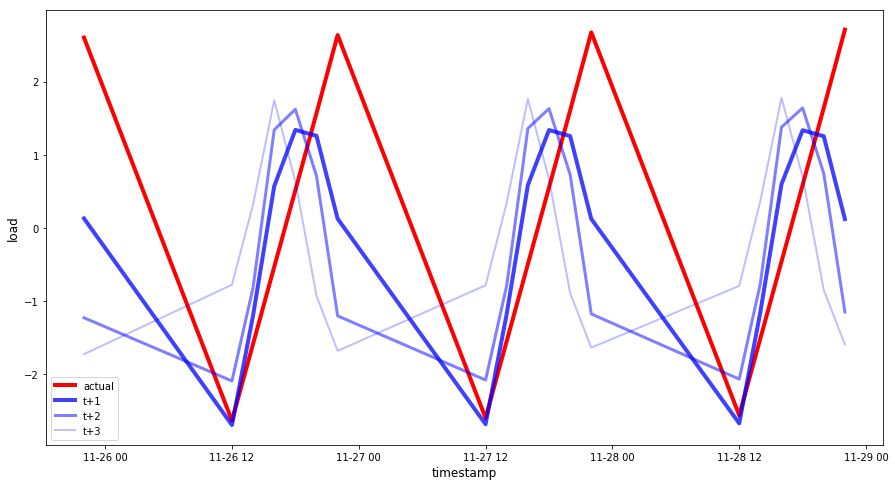

In [100]:
plot_df = eval_df[(eval_df.h=='t+1')][['timestamp', 'actual']]
for t in range(1, HORIZON+1):
    plot_df['t+'+str(t)] = eval_df[ (eval_df.h=='t+'+str(t))]['prediction'].values

fig = plt.figure(figsize=(15, 8))
ax = plt.plot(plot_df['timestamp'], plot_df['actual'], color='red', linewidth=4.0)
ax = fig.add_subplot(111)
ax.plot(plot_df['timestamp'], plot_df['t+1'], color='blue', linewidth=4.0, alpha=0.75)
ax.plot(plot_df['timestamp'], plot_df['t+2'], color='blue', linewidth=3.0, alpha=0.5)
ax.plot(plot_df['timestamp'], plot_df['t+3'], color='blue', linewidth=2.0, alpha=0.25)
plt.xlabel('timestamp', fontsize=12)
plt.ylabel('load', fontsize=12)
ax.legend(loc='best')
plt.show()

# take input here

In [39]:
a = df.iloc[156:162  , :]
a

,M0
Epoch_Time_of_Clock,
2017-11-28 12:00:00,2.67358948779000016316
2017-11-28 14:00:00,-2.55941955144999999661
2017-11-28 16:00:00,-1.50917480722999997056
2017-11-28 18:00:00,-0.45894344872299996929
2017-11-28 20:00:00,0.58887986470700004471
2017-11-28 22:00:00,1.64149733037999978613


In [40]:
new_df = pd.DataFrame()

In [41]:
columns = [var_name] 

In [42]:
for key , value in enumerate(columns):
    new_df[value] = a[value]

In [43]:
new_df = new_df.dropna( how = 'any')

In [44]:
new_df

,M0
Epoch_Time_of_Clock,
2017-11-28 12:00:00,2.67358948779000016316
2017-11-28 14:00:00,-2.55941955144999999661
2017-11-28 16:00:00,-1.50917480722999997056
2017-11-28 18:00:00,-0.45894344872299996929
2017-11-28 20:00:00,0.58887986470700004471
2017-11-28 22:00:00,1.64149733037999978613


In [45]:
# creating index for output
import datetime
date = new_df.index.date[0]
date + datetime.timedelta(1)

datetime.date(2017, 11, 29)

In [46]:
import datetime
date = new_df.index + datetime.timedelta(days =1)

In [47]:
date

DatetimeIndex(['2017-11-29 12:00:00', '2017-11-29 14:00:00',
               '2017-11-29 16:00:00', '2017-11-29 18:00:00',
               '2017-11-29 20:00:00', '2017-11-29 22:00:00'],
              dtype='datetime64[ns]', name='Epoch_Time_of_Clock', freq='2H')

In [48]:
new_df.index= date

In [49]:
new_df.columns

Index(['M0'], dtype='object')

In [50]:
print(new_df)
print(new_df.columns)

                                         M0
Epoch_Time_of_Clock                        
2017-11-29 12:00:00  2.67358948779000016316
2017-11-29 14:00:00 -2.55941955144999999661
2017-11-29 16:00:00 -1.50917480722999997056
2017-11-29 18:00:00 -0.45894344872299996929
2017-11-29 20:00:00  0.58887986470700004471
2017-11-29 22:00:00  1.64149733037999978613
Index(['M0'], dtype='object')


In [51]:
freq = None
idx_tuples = []
drop_incomplete  = True
new_df[[var_name]] = X_scaler.transform(new_df)
new_new_df = new_df.copy()
tensor_structure={'X':(range(-T+1, 1), [var_name])}
for name, structure in tensor_structure.items():
        rng = structure[0]
        dataset_cols = structure[1]
        for col in dataset_cols:
        # do not shift non-sequential 'static' features
            if rng is None:
                new_df['context_'+col] = new_df[col]
                idx_tuples.append((name, col, 'static'))
            else:
                for t in rng:
                    sign = '+' if t > 0 else ''
                    shift = str(t) if t != 0 else ''
                    period = 't'+sign+shift
                    shifted_col = name+'_'+col+'_'+ period
                    new_new_df[shifted_col] = new_new_df[col].shift(t*-1, freq=freq)
                    idx_tuples.append((name, col, period))
        new_new_df = new_new_df.drop(new_df.columns, axis=1)
        idx = pd.MultiIndex.from_tuples(idx_tuples, names=['tensor', 'feature', 'time step'])
        print(new_df.head())
        new_new_df.columns = idx
        if drop_incomplete:
            new_new_df = new_new_df.dropna(how='any')
            
inputs = {}           
for name, structure in tensor_structure.items():
    rng = structure[0]
    cols = structure[1]
    tensor = new_new_df[name][cols].as_matrix()
    if rng is None:
        tensor = tensor.reshape(tensor.shape[0], len(cols))
    else:
        tensor = tensor.reshape(tensor.shape[0], len(cols), len(rng))
        tensor = np.transpose(tensor, axes=[0, 2, 1])
    inputs[name] = tensor

                                         M0
Epoch_Time_of_Clock                        
2017-11-29 12:00:00  1.46251037533019556669
2017-11-29 14:00:00 -1.40505091126014880487
2017-11-29 16:00:00 -0.82954241368498748965
2017-11-29 18:00:00 -0.25404125115398629164
2017-11-29 20:00:00  0.32014036142260249296


In [52]:
print(new_new_df)
print(inputs['X'])

tensor                                   X                          \
feature                                 M0                           
time step                              t-5                     t-4   
Epoch_Time_of_Clock                                                  
2017-11-29 22:00:00 1.46251037533019556669 -1.40505091126014880487   

tensor                                                               \
feature                                                               
time step                               t-3                     t-2   
Epoch_Time_of_Clock                                                   
2017-11-29 22:00:00 -0.82954241368498748965 -0.25404125115398629164   

tensor                                                             
feature                                                            
time step                              t-1                      t  
Epoch_Time_of_Clock                                                
2017-11-29 22:00:00 0

In [53]:
predictions = model.predict(inputs['X'])

In [54]:
predictions

array([[-0.45999202, -0.705494  , -0.63428086, -0.2675387 ,  0.29441473,
         0.92141736]], dtype=float32)

In [55]:
print(predictions.shape)


(1, 6)


In [56]:
results = predictions[-1, :]

In [57]:
results

array([-0.45999202, -0.705494  , -0.63428086, -0.2675387 ,  0.29441473,
        0.92141736], dtype=float32)

In [58]:
res_df = pd.DataFrame(results , columns = [var_name])
res_df

,M0
0,-0.45999202132225036621
1,-0.70549398660659790039
2,-0.63428086042404174805
3,-0.26753869652748107910
4,0.29441472887992858887
5,0.92141735553741455078


In [59]:
res_df.index = date
res_df

,M0
Epoch_Time_of_Clock,
2017-11-29 12:00:00,-0.45999202132225036621
2017-11-29 14:00:00,-0.70549398660659790039
2017-11-29 16:00:00,-0.63428086042404174805
2017-11-29 18:00:00,-0.26753869652748107910
2017-11-29 20:00:00,0.29441472887992858887
2017-11-29 22:00:00,0.92141735553741455078


In [60]:
res_df[var_name] = y_scalar.inverse_transform(res_df[[var_name]])    

# final generated output 

In [61]:
# final generated ouput
res_df

,M0
Epoch_Time_of_Clock,
2017-11-29 12:00:00,-0.83478271961212158203
2017-11-29 14:00:00,-1.28279900550842285156
2017-11-29 16:00:00,-1.15284228324890136719
2017-11-29 18:00:00,-0.48357492685317993164
2017-11-29 20:00:00,0.54193323850631713867
2017-11-29 22:00:00,1.68614947795867919922


In [63]:
res_df.to_csv('SA1M0.csv')